# Detection summary

## Imports

The following libraries are used in this notebook:

- `cv2` (OpenCV): For video processing and image operations.
- `os`: For file and directory operations.
- `json`: For saving detection results in JSON format.
- `pandas` (`pd`): For data manipulation and analysis.
- `matplotlib.pyplot` (`plt`): For plotting and visualization.
- `ultralytics.YOLO`: For object detection using YOLO models.
- `collections.defaultdict`: For counting object classes efficiently.

In [1]:
import cv2
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
from collections import defaultdict

# Paths
VIDEO_PATH = 'input_video.mp4'  # Replace with actual path
OUTPUT_DIR = 'output'
ANNOTATED_DIR = os.path.join(OUTPUT_DIR, 'annotated_frames')
os.makedirs(ANNOTATED_DIR, exist_ok=True)

Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\nasaa\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [2]:
model = YOLO('yolov5s.pt')  # Loads YOLOv5s

PRO TIP  Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 17.7M/17.7M [00:03<00:00, 5.65MB/s]


## Detection Loop

This section processes the video frame by frame, running YOLO object detection every 5th frame. For each processed frame, it:

- Runs the YOLO model to detect objects.
- Records detected object classes and their bounding boxes.
- Updates a counter for each detected class.
- Tracks the diversity (number of unique classes) per frame.
- Saves the annotated frame as an image.
- Saves detection results for each frame in a JSON file.

In [3]:
cap = cv2.VideoCapture(VIDEO_PATH)
frame_count = 0
detections = {}
class_counter = defaultdict(int)
diversity_record = {}

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_count % 5 == 0:
        results = model(frame)[0]
        frame_json = []
        detected_classes = set()

        for r in results.boxes.data.tolist():
            x1, y1, x2, y2, conf, cls_id = r
            label = model.names[int(cls_id)]
            detected_classes.add(label)
            class_counter[label] += 1

            frame_json.append({
                'class': label,
                'bbox': [x1, y1, x2, y2],
                'confidence': float(conf)
            })

        detections[frame_count] = frame_json
        diversity_record[frame_count] = len(detected_classes)

        # Save annotated frame
        annotated_frame = results.plot()
        cv2.imwrite(f"{ANNOTATED_DIR}/frame_{frame_count}.jpg", annotated_frame)

        # Save JSON
        with open(f"{OUTPUT_DIR}/frame_{frame_count}.json", "w") as f:
            json.dump(frame_json, f, indent=2)

    frame_count += 1

cap.release()


0: 384x640 4 persons, 9 cars, 1 bus, 1 truck, 5 traffic lights, 137.3ms
Speed: 3.9ms preprocess, 137.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 10 cars, 1 bus, 1 truck, 4 traffic lights, 114.3ms
Speed: 1.9ms preprocess, 114.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 10 cars, 1 bus, 3 trucks, 3 traffic lights, 89.3ms
Speed: 2.1ms preprocess, 89.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 8 cars, 1 bus, 2 trucks, 5 traffic lights, 77.1ms
Speed: 0.8ms preprocess, 77.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 9 cars, 1 bus, 1 truck, 7 traffic lights, 123.8ms
Speed: 0.9ms preprocess, 123.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 8 cars, 1 bus, 1 truck, 6 traffic lights, 99.8ms
Speed: 0.8ms preprocess, 99.8ms inference, 0.8ms postprocess per image at

## Plotting bar graph for showcasing frequency

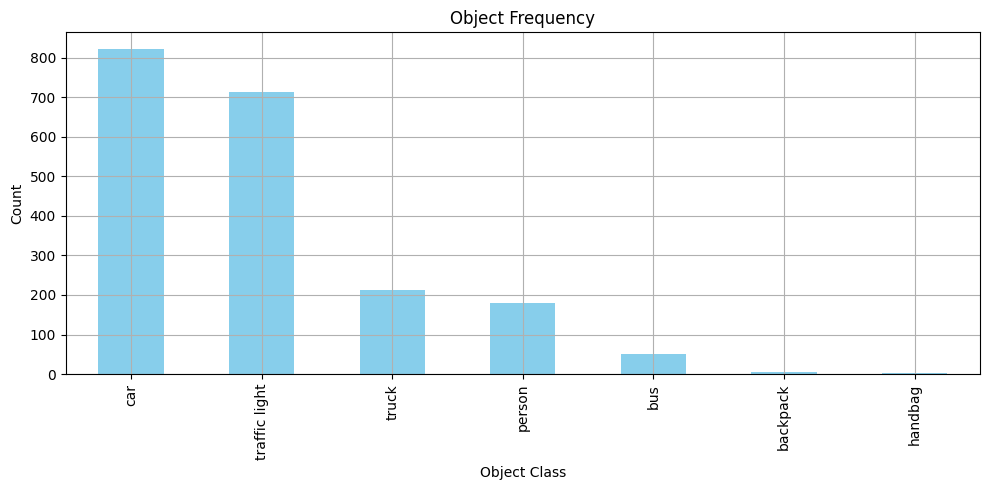

In [10]:
plt.figure(figsize=(10, 5))
pd.Series(class_counter).sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Object Frequency")
plt.xlabel("Object Class")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.savefig("class_frequency.png")
plt.show()

## Finding frame with maximum diversity

In [11]:
max_div_frame = max(diversity_record, key=diversity_record.get)
print(f"Frame with maximum class diversity: Frame {max_div_frame} with {diversity_record[max_div_frame]} unique classes")

Frame with maximum class diversity: Frame 290 with 6 unique classes
